# Packages

In [1]:
# Helpful packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
import split_vectorize
import base_models
import neural_nets

from IPython.display import display, HTML

# Get Data

In [2]:
# Uncomment the line below to create a new data file. Otherwise, skip to the next cell to import the existing file.
# %run parse_corpus.py 10000 # Number of articles to get

In [2]:
df = pd.read_csv('data/nyt_corpus.csv')
df.shape

(10000, 32)

### Possible Model Outputs

In [3]:
# possible labels - desk works best
df[['desk','general_descriptor','online_sections','taxonomic_classifier']][-10:]

,desk,general_descriptor,online_sections,taxonomic_classifier
9990,Editorial Desk,"['Budgets and Budgeting', 'National Debt (US)'...",Opinion,"['Top/Opinion', 'Top/Opinion/Opinion', 'Top/Ne..."
9991,Foreign Desk,"['Immigration and Refugees', 'Jews', 'Music', ...",World,"['Top/News', 'Top/News/World/Countries and Ter..."
9992,Foreign Desk,['Airlines and Airplanes'],NaN,['Top/Classifieds/Job Market/Job Categories/Ma...
9993,Metropolitan Desk,"['Murders and Attempted Murders', 'Basketball'...",New York and Region,"['Top/News/U.S./U.S. States, Territories and P..."
9994,Book Review Desk,['Books and Literature'],Arts; Books,"['Top/Features/Books/Book Reviews', 'Top/Featu..."
9995,Editorial Desk,NaN,Opinion,"['Top/Opinion/Opinion/Letters', 'Top/Opinion',..."
9996,National Desk,NaN,U.S.,"['Top/News/U.S.', 'Top/News']"
9997,Metropolitan Desk,NaN,New York and Region,['Top/News/New York and Region']
9998,Classified,NaN,Paid Death Notices,['Top/Classifieds/Paid Death Notices']
9999,Leisure/Weekend Desk,NaN,Arts,['Top/Features/Arts']


In [4]:
# pct nulls for each possible labels
(df.shape[0] - df[['desk','general_descriptor','online_sections','taxonomic_classifier']].count()) / df.shape[0]

desk                    0.0041
general_descriptor      0.2140
online_sections         0.0244
taxonomic_classifier    0.0144
dtype: float64

# Preprocess Data

In [6]:
# Uncomment the line below to run pre-processing on the parsed data file.
# Otherwise, skip to the next cell to import the existing preprocessed file.
# %run preprocessing.py

Imported data file
Created nouns and lemmas for 1000 articles
Created nouns and lemmas for 2000 articles
Created nouns and lemmas for 3000 articles
Created nouns and lemmas for 4000 articles
Created nouns and lemmas for 5000 articles
Created nouns and lemmas for 6000 articles
Created nouns and lemmas for 7000 articles
Created nouns and lemmas for 8000 articles
Created nouns and lemmas for 9000 articles
Created nouns and lemmas for 10000 articles
Created nouns and lemmas for all articles
Cleaned labels
Saved new data file


In [2]:
df_final = pd.read_csv('data/nyt_corpus_cleaned.csv')
print(df_final.shape)
df_final.head()

(10000, 6)


,desk,full_text,lead_paragraph,headline,nouns,lemmas
0,business & financial,"The Bethlehem Steel Corporation, after report...","The Bethlehem Steel Corporation, after report...",Bethlehem Halts Dividends And Plans Cuts After...,Bethlehem Steel Corporation loss quarter yeste...,"The Bethlehem Steel Corporation , after report..."
1,foreign,Seeking to raise morale at home and improve i...,Seeking to raise morale at home and improve i...,World News Briefs;Iraqis Elect Parliament Pre-...,morale home image Iraq today elections candida...,Seeking to raise morale at home and improve it...
2,editorial,By the time Lord Elgin obtained the authority...,By the time Lord Elgin obtained the authority...,Return the Parthenon Marbles,time Lord Elgin authority pieces stone inscrip...,By the time Lord Elgin obtain the authority to...
3,classified,SPEIER-Claire. Born New York City. Age 70. Gr...,SPEIER-Claire. Born New York City. Age 70. Gr...,"Paid Notice: Deaths SPEIER, CLAIRE",SPEIER-Claire. Born New York City. Age Graduat...,SPEIER-Claire. Born New York City. Age 70. Gra...
4,national,LEAD: The Japanese videotape begins with the ...,LEAD: The Japanese videotape begins with the ...,Not Fit to Import?,LEAD videotape words tables foods. tape inspec...,LEAD : The Japanese videotape begin with the w...


In [8]:
label_transform = pd.concat([df_final.desk, df.desk], axis=1)
label_transform.columns = ['desk_cleaned', 'desk']
label_transform.groupby(['desk_cleaned','desk']).size().reset_index(name='cnt').set_index(['desk_cleaned','desk'])[:20]

cnt
desk_cleaned         desk                                      
a nation challenged  A Nation Challenged                      1
arts & leisure       Arts & Ideas/Cultural Desk              18
                     Arts & Leisure Desk                     29
                     Arts and Leisure Desk                  129
                     Cultural Desk                          231
                     Leisure/Weekend Desk                    56
                     Movies, Performing Arts/Weekend Desk    80
                     Museums                                  1
                     The Arts/Cultural Desk                 219
                     Weekend Desk                           115
                     Weekend DeskWeekend Desk                 4
book review          Book Review Desk                       176
business & financial Business World Magazine                  1
                     Business/Finance Desk                    1
                     Business/Financial Desk                628
                     Business\Financial Desk                  1
                     E-Commerce                               1
                     Financial Desk                        1106
                     Financial Desk;                          2
                     Money and Business/Financial Desk       79

### Train/Dev/Test Split and TF-IDF Vectorize

/Users/carmen/Documents/NLP/w266-final-project/split_vectorize.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = self.df[[self.articles, self.labels]][self.df[self.articles].notnull()][self.df[self.labels].notnull()]


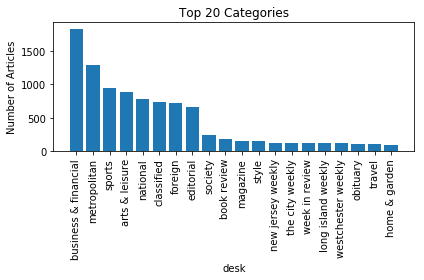

In [3]:
reload(split_vectorize)
rand_seed = 102 # Random number to feed in so all models will assign same articles to train/dev/test sets

# Create object for each of the model inputs
full_text = split_vectorize.SplitVectorize(df_final, 'full_text', 'Full Text')
lead_para = split_vectorize.SplitVectorize(df_final, 'lead_paragraph', 'Lead Paragraph')
headlines = split_vectorize.SplitVectorize(df_final, 'headline', 'Headlines')
nouns = split_vectorize.SplitVectorize(df_final, 'nouns', 'Nouns Only')
lemmas = split_vectorize.SplitVectorize(df_final, 'lemmas', 'Lemmatized')

all_inputs = [full_text, lead_para, headlines, nouns, lemmas]

# Split into train/test data and TF-IDF vectorize
for x in all_inputs:
    x.train_test_split(rand_seed)
    x.tfidf_vectorize()

In [7]:
html = '<table><th>Article Type</th><th>Training Articles</th><th>Training Words</th><th>% Training Words</th>'
html += '<th>Avg. Words per Training Article</th><th>Training Vocab Size</th><th>% Training Vocab</th>'
html += '<th>Avg. Unique Words per Training Article</th><th>Dev Articles</th><th>Test Articles</th></tr>'

for x in all_inputs:
    html += '<tr><td>{}</td><td>{:,}</td><td>{:,}</td>'.format(x.name_, x.tv_train.shape[0], x.train_words_)
    html += '<td>{:.0%}</td><td>{:.0f}</td>'.format(x.train_words_/full_text.train_words_, x.train_avg_words_)
    html += '<td>{:,}</td><td>{:.0%}</td>'.format(x.train_vocab_size_, x.train_vocab_size_/full_text.train_vocab_size_)
    html += '<td>{:,.0f}</td><td>{:,}</td><td>{:,}</td></tr>'.format(x.train_avg_unq_words_, x.tv_dev.shape[0], x.tv_test.shape[0])

html += '</table>'
display(HTML(html))

Full Text,"7,356","4,684,947",100%,637,"85,864",100%,264,513,"1,978"
Lead Paragraph,"7,169","692,307",15%,97,"39,890",46%,61,499,"1,922"
Headlines,"7,459","54,968",1%,7,"11,127",13%,6,516,"2,022"
Nouns Only,"7,355","1,439,061",31%,196,"69,721",81%,122,513,"1,978"
Lemmatized,"7,356","4,684,954",100%,637,"80,328",94%,249,513,"1,978"


# Baseline Models

### Multinomial Naïve Bayes

In [8]:
reload(base_models)
mnb = base_models.MultNB()

for x in all_inputs:
    mnb.test_models(x)

Best Multinomial Naïve Bayes model:
input       Nouns Only
alpha       0.00390625
accuracy    0.72319688
Name: 98, dtype: object


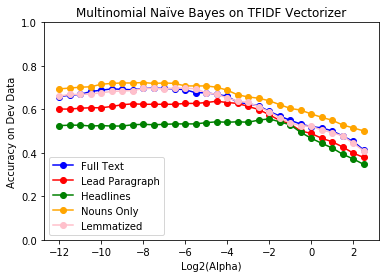

In [9]:
reload(base_models)

mnb_tables = []
for x in all_inputs:
    mnb_tables.append(x.mnb_accuracy_table_)

mnb.plot_accuracy(mnb_tables)

### Logistic Regression

In [10]:
reload(base_models)
lr = base_models.LogReg()

for x in all_inputs:
    lr.test_models(x)

Best Logistic Regression model:
input         Full Text
penalty              L2
C          100.00000000
accuracy     0.76998051
Name: 23, dtype: object


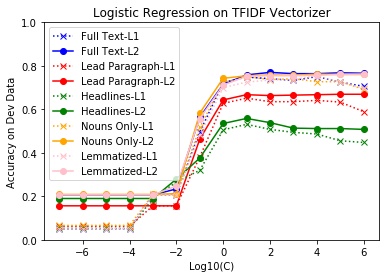

In [11]:
reload(base_models)

lr_tables = []
for x in all_inputs:
    lr_tables.append(x.lr_accuracy_table_)

lr.plot_accuracy(lr_tables)

In [12]:
html = '<table><th>Model Input</th><th>MNB Parameters</th><th>MNB Accuracy</th>'
html += '<th>LR Parameters</th><th>LR Accuracy</th>'

for x in all_inputs:
    alpha = 'alpha = 2^'+str(np.log2(x.best_mnb_model_.alpha))
    html += '<tr><td>{}</td><td>{}</td><td>{:.3f}</td>'.format(x.name_, alpha, max(x.mnb_accuracy_table_.accuracy))
    C = 'C = 10^'+str(np.log10(x.best_lr_model_.C))
    penalty = 'penalty = '+x.best_lr_model_.penalty
    html += '<td>{}</td><td>{:.3f}</td></tr>'.format(C+'; '+penalty, max(x.lr_accuracy_table_.accuracy))

html += '</table>'
display(HTML(html))

Full Text,alpha = 2^-7.5,0.698,C = 10^2.0; penalty = l2,0.770
Lead Paragraph,alpha = 2^-4.5,0.637,C = 10^5.0; penalty = l2,0.669
Headlines,alpha = 2^-2.0,0.556,C = 10^1.0; penalty = l2,0.558
Nouns Only,alpha = 2^-8.0,0.723,C = 10^4.0; penalty = l2,0.762
Lemmatized,alpha = 2^-6.5,0.698,C = 10^6.0; penalty = l2,0.762


# Complex Models

### Neural Network

In [35]:
reload(neural_nets)
nn = neural_nets.NeuralNets()
#nn.load_glove_vectors()

for x in all_inputs:
    nn.tokenize_pad(x)
    
# 80% pad: .
# 90% pad: 1218,  138, 10,  408, 1241
# no  pad: 7555, 5974, 55, 3296, 7556

Created index of 100-dimensional embeddings for 400,000 words.
Full Text:
	103,042 unique tokens
	Created matrix of 100-dimensional weights for 103,043 tokens
	Training data shape: (7356, 1218)
Lead Paragraph:
	43,699 unique tokens
	Created matrix of 100-dimensional weights for 43,700 tokens
	Training data shape: (7169, 138)
Headlines:
	11,706 unique tokens
	Created matrix of 100-dimensional weights for 11,707 tokens
	Training data shape: (7459, 10)
Nouns Only:
	70,353 unique tokens
	Created matrix of 100-dimensional weights for 70,354 tokens
	Training data shape: (7355, 408)
Lemmatized:
	81,442 unique tokens
	Created matrix of 100-dimensional weights for 81,443 tokens
	Training data shape: (7356, 1241)


In [36]:
nn.neural_net(full_text)

Compiled
Epoch 1/5
7356/7356 [==============================] - 1s 191us/step - loss: 2.5124 - acc: 0.2946
Epoch 2/5
7356/7356 [==============================] - 1s 164us/step - loss: 2.0020 - acc: 0.4322
Epoch 3/5
7356/7356 [==============================] - 1s 164us/step - loss: 1.7751 - acc: 0.5083
Epoch 4/5
7356/7356 [==============================] - 1s 164us/step - loss: 1.6493 - acc: 0.5328
Epoch 5/5
7356/7356 [==============================] - 1s 165us/step - loss: 1.5611 - acc: 0.5606
Fit
1978/1978 [==============================] - 0s 179us/step
Test loss: 4.32084581463836
Test accuracy: 0.11476238628640334
First prediction (probabilities): [1.3763154e-01 1.2798142e-03 2.8146342e-03 6.0451133e-09 4.7635335e-02
 1.6004731e-01 2.1727227e-02 8.2188030e-04 1.1213558e-03 5.3727001e-01
 6.4851460e-03 1.5408814e-02 2.4912732e-03 8.9037772e-03 6.0734237e-05
 5.7639686e-06 1.1485079e-02 1.4205658e-02 9.0807742e-03 1.6242409e-02
 5.2814754e-03]
First prediction (category): 9
First test

In [39]:
nn.neural_net(headlines)

Compiled
Epoch 1/5
7459/7459 [==============================] - 1s 68us/step - loss: 2.1616 - acc: 0.4027
Epoch 2/5
7459/7459 [==============================] - 0s 35us/step - loss: 1.6478 - acc: 0.5351
Epoch 3/5
7459/7459 [==============================] - 0s 35us/step - loss: 1.5303 - acc: 0.5505
Epoch 4/5
7459/7459 [==============================] - 0s 35us/step - loss: 1.4706 - acc: 0.5666
Epoch 5/5
7459/7459 [==============================] - 0s 36us/step - loss: 1.4351 - acc: 0.5725
Fit
2022/2022 [==============================] - 0s 61us/step
Test loss: 5.264372144089726
Test accuracy: 0.0830860534124629
First prediction (probabilities): [3.6216214e-01 7.7869631e-03 1.4641655e-02 2.0571592e-07 2.1535961e-02
 1.3715844e-01 1.5649814e-02 1.1477764e-02 2.6305749e-03 2.8815842e-01
 2.0886685e-03 9.2350608e-03 1.9650981e-02 2.8731670e-02 6.2485771e-05
 1.8460103e-07 1.7342042e-02 2.4770068e-02 1.9601358e-02 1.0899558e-02
 6.4159855e-03]
First prediction (category): 0
First test label

# Error Analysis

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
for x in [full_text]:#, lead_para, headlines, nouns, lemmas]:
    print('\n', x.name_, ':')
    print(classification_report(x.dev_labels, x.best_mnb_model_.predict(x.tv_dev)))
    print(confusion_matrix(x.dev_labels, x.best_mnb_model_.predict(x.tv_dev), labels=list(x.dev_labels.unique())))

In [ ]:
x.dev_labels.unique()

In [74]:
#full_text.train_labels#.groupby('desk')
df_final.groupby('desk', as_index=False).count().sort_values(by=['headline'], ascending=False).reset_index().rename(columns={'headline':'cnt'})[['desk','cnt']]
#.filter(lambda x: x.desk.count() >= 100).groupby('desk')['desk'].count()
# 47 topics total (9959 articles). 32 (9933) with >=10. 29 (9889) with >= 20.
# 27 (9844) with >= 25,30,40. 24 (9707) with >= 50. 20 (9380) with >= 100.

,desk,cnt
0,business,1832
1,metropolitan,1292
2,sports,947
3,arts,881
4,national,785
5,classified,734
6,foreign,723
7,editorial,666
8,society,242
9,book review,176
